In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install tensorboard torchinfo torch-summary matplotlib scipy opencv-python SimpleITK

Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import cv2
import numpy as np


# TODO: call load_dataset instead of inline here

dataset_name = "cxr8"

base_data_path = Path("C:\\") / "data"

imagenet_data_path = (
    base_data_path
    / "imagenet-object-localization-challenge"
    / "ILSVRC"
    / "Data"
    / "CLS-LOC"
)

cxr8_data_path = base_data_path / "cxr8" / "filtered"

CLAHE_TILE = 8
clahe = cv2.createCLAHE(clipLimit=4, tileGridSize=(CLAHE_TILE, CLAHE_TILE))

input_size = (1, 448, 448)

if dataset_name == "cxr8":
    train_dataset = datasets.ImageFolder(
        cxr8_data_path,
        transform=transforms.Compose(
            [
                transforms.Resize((input_size[1], input_size[2])),
                transforms.Grayscale(),
                transforms.Lambda(np.array),
                transforms.Lambda(clahe.apply),
                transforms.ToTensor(),
            ]
        ),
    )
elif dataset_name == "cifar10":
    train_dataset = datasets.CIFAR10(
        root="./data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [transforms.Resize((224, 224)), transforms.ToTensor()]
        ),
    )
elif dataset_name == "imagenet":
    train_dataset = datasets.ImageFolder(
        imagenet_data_path,
        transform=transforms.Compose(
            [transforms.Resize((224, 224)), transforms.ToTensor()]
        ),
    )

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [4]:
import torch
from torchinfo import summary

from vae import VAE, vae_loss

KERNEL_SIZE = 13
DIRECTIONS = 7
LATENT_DIM = 128  # 64
show_summary = True

# model = VAE((1 if dataset_name == "cxr8" else 3, 224, 224), latent_dim).to(device)
model = VAE(input_size, init_kernel_size=KERNEL_SIZE, latent_dim=LATENT_DIM)
if show_summary:
    print(
        summary(
            model,
            input_size=(37, input_size[0], input_size[1], input_size[2]),
            depth=10,
            col_names=[
                "input_size",
                "kernel_size",
                "mult_adds",
                "num_params",
                "output_size",
                "trainable",
            ],
        )
    )

device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(device)

model = model.to(device)
print(set([p.device for p in model.parameters()]))


make_oriented_map: weights_real.shape = torch.Size([40, 1, 13, 13])
self.in_planes 40
self.input_size_to_fc = [512, 14, 14]
Layer (type:depth-idx)                        Input Shape               Kernel Shape              Mult-Adds                 Param #                   Output Shape              Trainable
VAE                                           [37, 1, 448, 448]         --                        --                        --                        [37, 1, 448, 448]         Partial
├─Encoder: 1-1                                [37, 1, 448, 448]         --                        --                        --                        [37, 128]                 Partial
│    └─Conv2d: 2-1                            [37, 1, 448, 448]         [13, 13]                  12,550,021,120            (6,760)                   [37, 40, 224, 224]        False
│    └─Conv2d: 2-2                            [37, 1, 448, 448]         [13, 13]                  12,550,021,120            (6,760)         

c:\dev\resnet18-vae\venv310\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


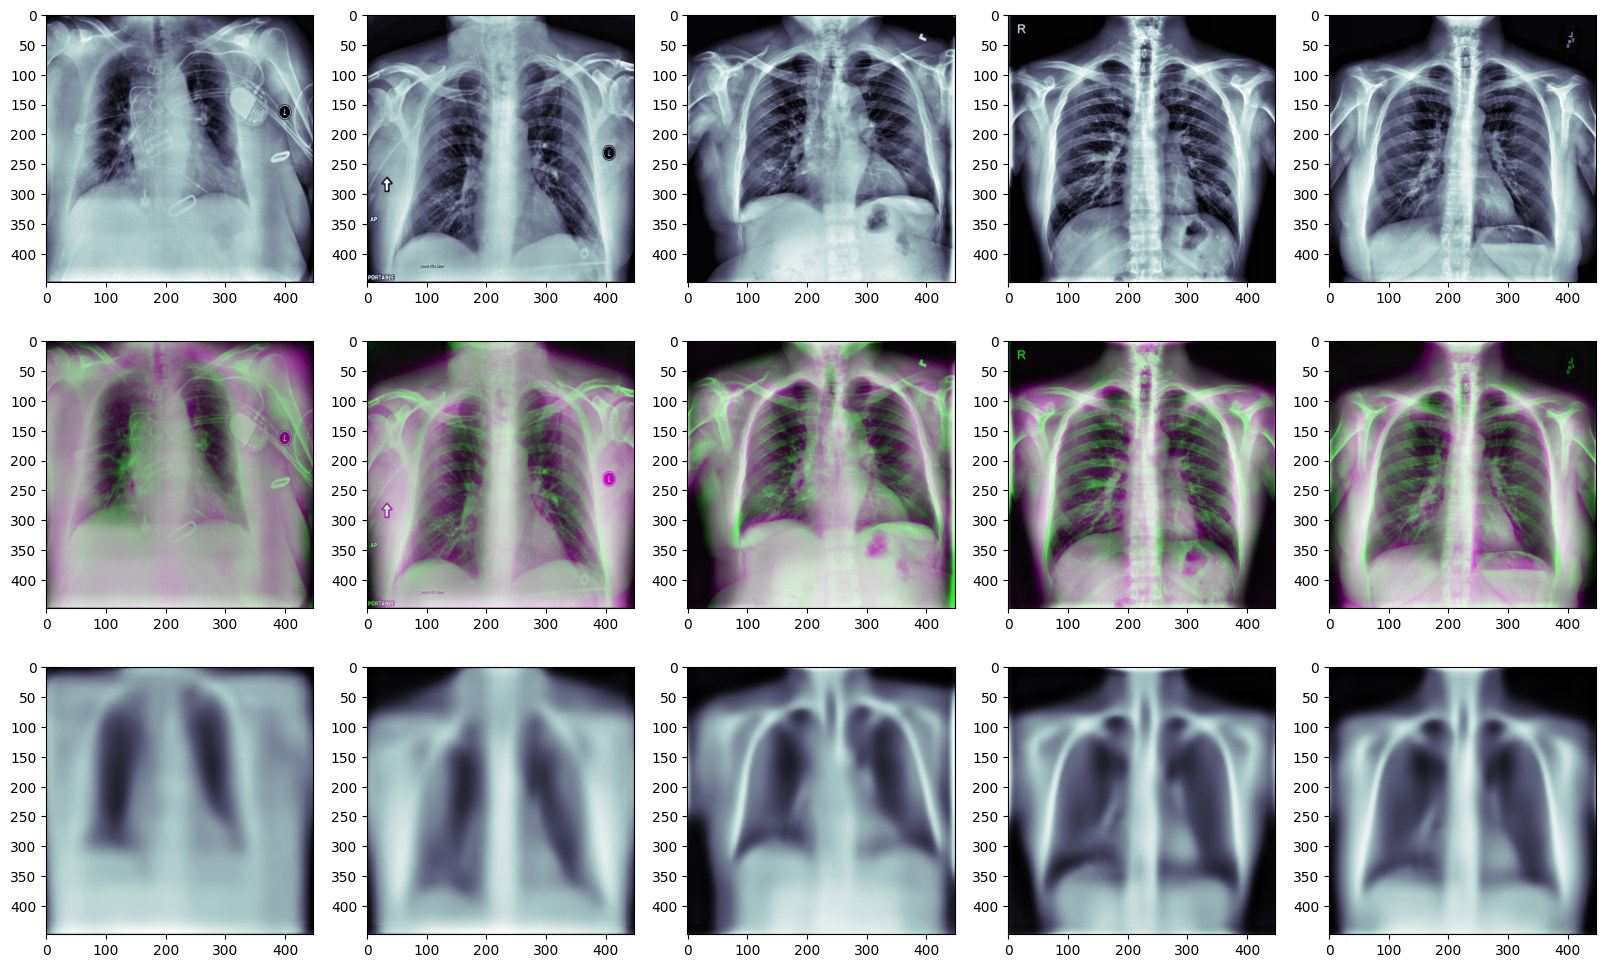

Epoch [3/3], Batch: 940, Loss: 0.108528 (0.094000/0.148675)
Epoch [3/3], Batch: 941, Loss: 0.108527 (0.092162/0.151277)
Epoch [3/3], Batch: 942, Loss: 0.108522 (0.089473/0.144903)
Epoch [3/3], Batch: 943, Loss: 0.108519 (0.087442/0.180926)


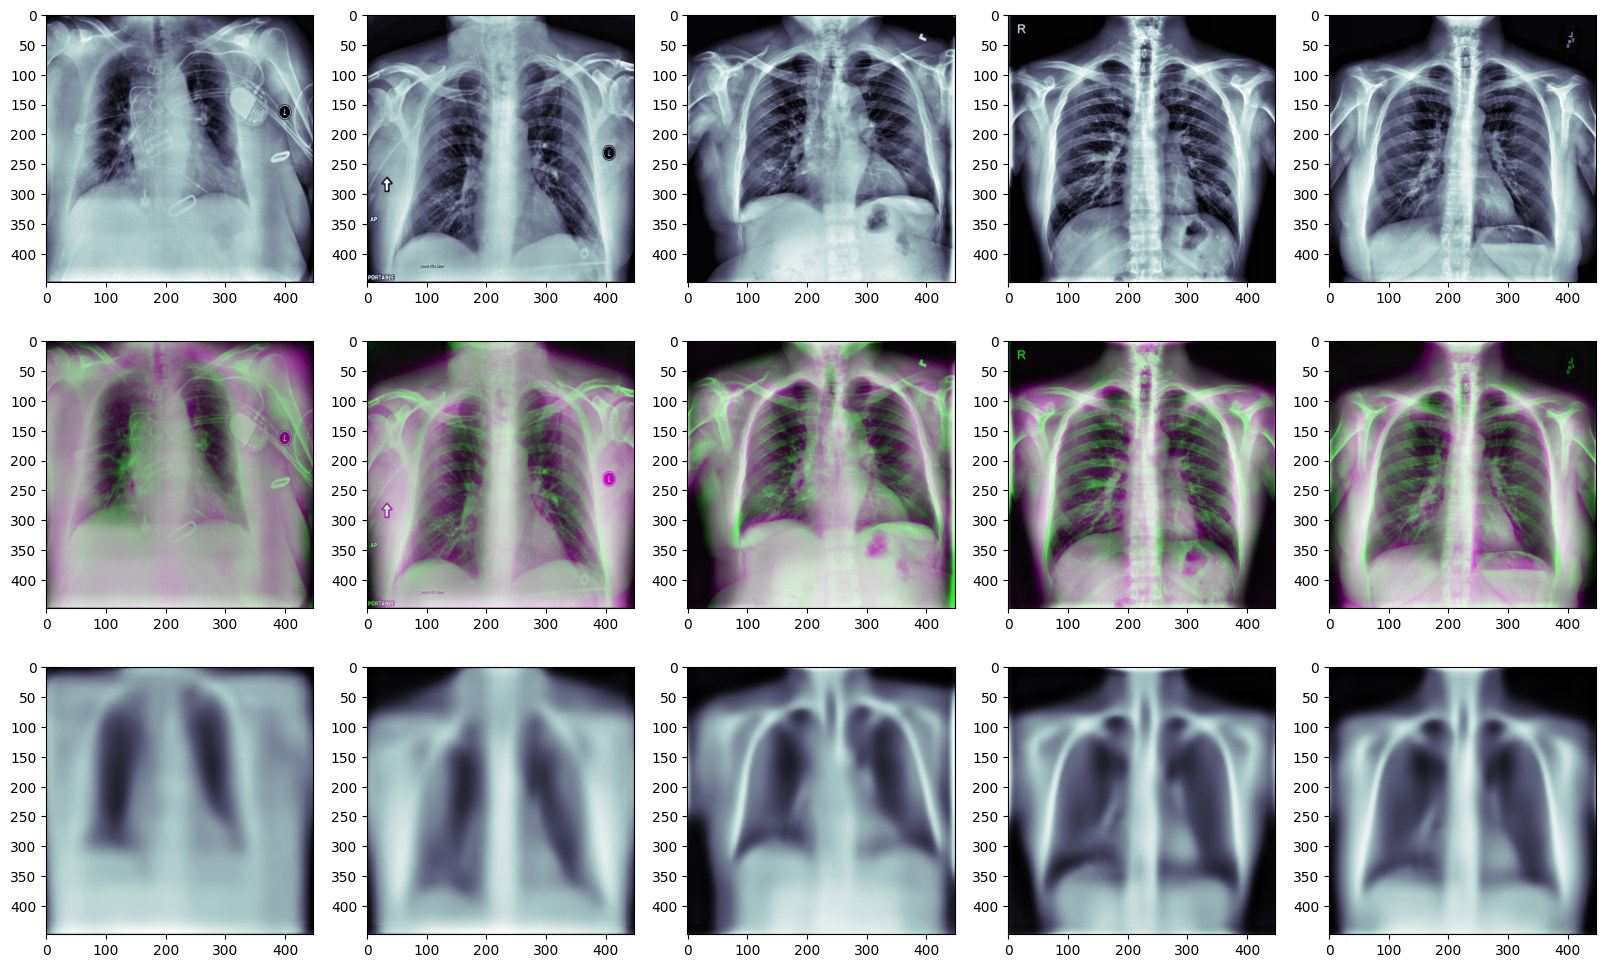

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import torch.nn.functional as F

num_epochs = 3

import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=1e-4)

fig, ax = plt.subplots(3, 5, figsize=(20,12))

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_count = 0
    for batch_idx, (data, _) in enumerate(train_loader):

        data = data.to(device)
        optimizer.zero_grad()

        recon_batch, mu, log_var, x_after_v1, x_after_v2, x_before_v2, x_before_v1 = model(data)
        # print(f"data = {data.shape}")
        # print(f"recon_batch = {recon_batch.shape}")
        # print(f"mu = {mu.shape}")
        # print(f"log_var = {log_var.shape}")
        # print(f"x_after_v1 = {x_after_v1.shape}")
        # print(f"x_after_v2 = {x_after_v2.shape}")
        # print(f"x_before_v2 = {x_before_v2.shape}")
        # print(f"x_before_v1 = {x_before_v1.shape}")
        x_after_v1_weight = torch.tensor(  
            [1.0**4] * 8
            + [0.9**4] * 8
            + [0.8**4] * 8
            + [0.7**4] * 8
            + [0.6**4] * 8
        )
        recon_loss, kldiv_loss, loss = vae_loss(
            recon_batch, data, mu, log_var, x_after_v1, x_after_v1_weight, x_after_v2, x_before_v2, x_before_v1,
            recon_loss_metric="l1_loss",  beta=0.1
        )

        if train_count % 10 == 0:
            data = data[0:5].clone()
            orig_data = data # model.stn(data)
            orig_data = orig_data.cpu().detach().numpy()

            recon_batch = recon_batch[0:5].clone()
            recon_data = recon_batch.cpu().detach().numpy()

            blend_data = 0.5 * orig_data + 0.5 * recon_data
            blend_data = np.stack([recon_data, orig_data,recon_data], axis=-1)

            # print(v.shape)
            for n in range(5):
                ax[0][n].imshow(np.squeeze(orig_data[n]), cmap='bone')
                ax[1][n].imshow(np.squeeze(blend_data[n])) # cmap='bone')
                ax[2][n].imshow(np.squeeze(recon_data[n]), cmap='bone')

            clear_output(wait=True)

            display(plt.gcf())

        loss.backward()
        train_loss += loss.item()
        train_count += 1.0
        optimizer.step()

        print(
            f"Epoch [{epoch+1}/{num_epochs}], Batch: {batch_idx}, Loss: {train_loss / train_count:.6f} ({recon_loss:.6f}/{kldiv_loss:.6f})"
        )


In [8]:
from datetime import datetime

when = datetime.now().strftime("%Y%m%d%H%M%S")
weight_path = (
    Path("weights")
    / f"{when}_clahe{CLAHE_TILE}_kernel{KERNEL_SIZE}_latent{LATENT_DIM}_orisq.zip"
)

torch.save(model.state_dict(), weight_path)
